# Kaggle-Cassava-Leaf-Disease-Classification
__Main Goal__

+ Classifying each image in one of the five possible classes
+ Source: https://www.kaggle.com/c/cassava-leaf-disease-classification
+ This notebook is for the training phase

In [1]:
#Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from pathlib import Path
import math

In [2]:
#Loading fastai modules
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
from fastai.vision import *
import fastai
import torch
from fastai.callback.all import SaveModelCallback
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, cohen_kappa_score

In [3]:
print("Fastai version: ",fastai.__version__)

Fastai version:  2.2.5


In [4]:
print("GPU available: ",torch.cuda.get_device_name(0))

GPU available:  GeForce GTX 1080 Ti


In [5]:
#Showing and saving the graphs within this notebook
%matplotlib inline
#Reload automatically the modules after executing each cell
%reload_ext autoreload
%autoreload 2

In [6]:
#Path to your csv and images folders
path = Path('../input/cassava-leaf-disease-classification')

In [7]:
data=pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

In [8]:
data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


# Functions

In [9]:
def get_x(r): return path/'train_images'/r['image_id']
def get_y(r): return r['label']

In [10]:
def gen_data(size, pre_size,bs=64,metodo='method1'):
    if(metodo=='method1'):
        datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    item_tfms=Resize(pre_size),
                    get_x=get_x, 
                    get_y=get_y,
                    batch_tfms=aug_transforms(size=size, min_scale=0.95))
    elif(metodo=='method2'):
         datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    item_tfms=Resize(pre_size),
                    get_x=get_x, 
                    get_y=get_y,
                    batch_tfms=aug_transforms())

    return datablock.dataloaders(data,batch_size=bs)

def create_learn(dls, multi_gpu=True, mixup=False, label_smooth_eps=0.1, model=resnet50,metrics=accuracy):
    if mixup==False:
        learn = cnn_learner(dls, model, metrics=metrics, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = cnn_learner(dls, model, metrics=metrics, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    if multi_gpu:
        learn.model = nn.DataParallel(learn.model) 
        print('multi-gpu enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=list(learn.dls.vocab)))

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

+ **After several attempts, this configuration was the best one**

# Training

`Resize(512px)`,`xresnet50`,`fit_one_cycle`(Fit a model following the `1cycle policy`),`50 epochs`, default augmentations, batch_size=32, metrics=`accuracy, RocAuc`, loss=`CrossEntropyLoss`, `mixup`, `weight_decay`=0.1, `LabelSmoothingCrossEntropy`

In [11]:
data=gen_data(356,512,32,'method2')

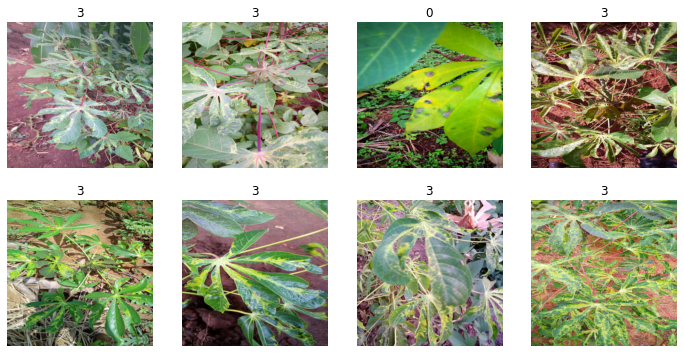

In [12]:
data.train.show_batch(nrows=2,ncols=4)

In [14]:
# We need to download the pretrained model manually because we were not allowed to use the internet on the competition.
# Then we need to copy it from our computer to kaggle and move it to the /root/.cache/torch/ folder
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/xresnetweights/xrn50_940.pth' '/root/.cache/torch/hub/checkpoints/xrn50_940.pth'

In [15]:
learn=create_learn(data,model=xresnet50,mixup=True,metrics=[accuracy,RocAuc()])

mixup enabled
multi-gpu enabled


In [16]:
learn.model_dir='/kaggle/working/models'

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(50,1e-2,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.357256,1.327331,0.668848,0.798783,07:30
1,1.155308,1.081496,0.695490,0.834952,06:52
2,1.088525,0.975886,0.714653,0.875905,06:53
3,1.072452,0.952096,0.729142,0.891881,06:53
4,1.046435,0.885930,0.761860,0.914448,06:54
5,1.027522,0.894157,0.759523,0.919421,06:56
6,0.969999,0.855835,0.773545,0.925297,06:54
7,0.967090,0.820999,0.780322,0.934605,06:52
8,0.951044,0.850022,0.786632,0.930735,06:54
9,0.977560,0.808134,0.807899,0.937477,06:53


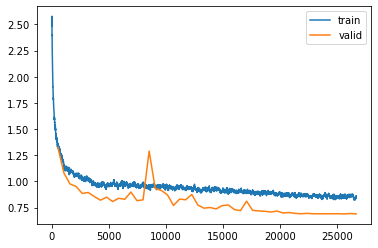

In [19]:
learn.recorder.plot_loss()

In [20]:
#We save the model now to load it later when doing the inference
filename = 'finalized_model.sav'
pickle.dump(learn, open(filename, 'wb'))